**Thêm thư viện cần thiết**

In [1]:
import tensorflow as tf

# Cấu hình TensorFlow sử dụng GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Giới hạn bộ nhớ GPU tránh chiếm hết
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPUs are ready for TensorFlow.")
    except RuntimeError as e:
        print(e)


GPUs are ready for TensorFlow.


In [2]:
# Thêm thư viện
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
import re
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import Add
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image as keras_image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.image as mpimg
from tqdm import tqdm
from tensorflow.keras.layers import (
    Dropout, MultiHeadAttention, Add, LayerNormalization
)
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.layers import Lambda, Input

**Chuẩn bị dữ liệu**

In [3]:
# Đường dẫn tới file CSV
csv_path = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"
image_dir = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"

# Đọc file CSV
data = pd.read_csv(csv_path, delimiter='|', names=['image_name', 'comment_number', 'comment'], skiprows=1)
data['comment'] = data['comment'].fillna('')

# Làm sạch và chuẩn bị từ điển ảnh-mô tả
image_map = {}
def clean_text(sentence):
    sentence = sentence.lower()
    # Làm sạch câu
    cleaned = re.sub(r"[^a-zA-Z0-9.,\s]", "", sentence)
    # Tách câu thành danh sách từ
    words = cleaned.split()
    # Nếu câu mô tả có số từ lớn hơn 48 -> chỉ giữ lại 48 từ đầu tiên
    if len(words) > 48:
        cleaned = " ".join(words[:48])
    return cleaned

for _, row in data.iterrows():
    image_name = row['image_name'].strip()
    comment = row['comment'].strip()
    comment = clean_text(comment)
    comment = f"start {comment} end" 
    if image_name not in image_map:
        image_map[image_name] = []
    image_map[image_name].append(comment)
    
# Kiểm tra kết quả
print(f"Số lượng ảnh: {len(image_map)}")
for image, comments in list(image_map.items())[:3]:  # Hiển thị bình luận của 3 ảnh đầu tiên
    print(f"\nẢnh: {image}")
    print("Bình luận:")
    print(comments)

Số lượng ảnh: 31783

Ảnh: 1000092795.jpg
Bình luận:
['start two young guys with shaggy hair look at their hands while hanging out in the yard . end', 'start two young , white males are outside near many bushes . end', 'start two men in green shirts are standing in a yard . end', 'start a man in a blue shirt standing in a garden . end', 'start two friends enjoy time spent together . end']

Ảnh: 10002456.jpg
Bình luận:
['start several men in hard hats are operating a giant pulley system . end', 'start workers look down from up above on a piece of equipment . end', 'start two men working on a machine wearing hard hats . end', 'start four men on top of a tall structure . end', 'start three men on a large rig . end']

Ảnh: 1000268201.jpg
Bình luận:
['start a child in a pink dress is climbing up a set of stairs in an entry way . end', 'start a little girl in a pink dress going into a wooden cabin . end', 'start a little girl climbing the stairs to her playhouse . end', 'start a little girl c


Ảnh: 1000092795.jpg


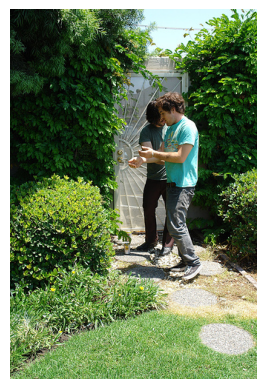

Bình luận:
['start two young guys with shaggy hair look at their hands while hanging out in the yard . end', 'start two young , white males are outside near many bushes . end', 'start two men in green shirts are standing in a yard . end', 'start a man in a blue shirt standing in a garden . end', 'start two friends enjoy time spent together . end']

Ảnh: 10002456.jpg


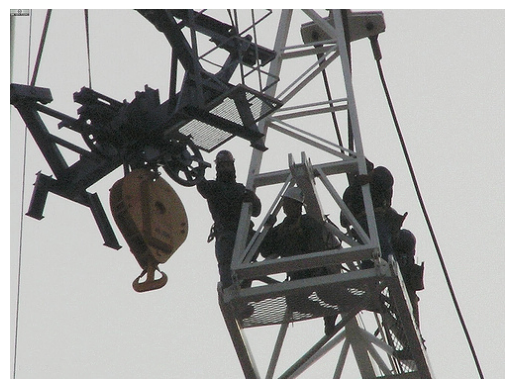

Bình luận:
['start several men in hard hats are operating a giant pulley system . end', 'start workers look down from up above on a piece of equipment . end', 'start two men working on a machine wearing hard hats . end', 'start four men on top of a tall structure . end', 'start three men on a large rig . end']


In [4]:
# Đường dẫn thư mục chứa ảnh
image_dir = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"

# Hiển thị ảnh từ image_map
for image_name, comments in list(image_map.items())[:2]:  # Hiển thị 2 ảnh đầu tiên
    # Tạo đường dẫn đầy đủ đến ảnh
    image_path = image_dir + image_name
    print(f"\nẢnh: {image_name}")
    
    # Đọc và hiển thị ảnh
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Tắt hiển thị trục
    plt.show()
    
    print("Bình luận:")
    print(comments)

In [5]:
# Chia tập train, val, test
total_images = len(image_map)
val_size = int(total_images * 0.15)
test_size = int(total_images * 0.01)
train_size = total_images - val_size - test_size

sorted_image_names = sorted(image_map.keys())
train_images = sorted_image_names[:train_size]
val_images = sorted_image_names[train_size:train_size + val_size]
test_images = sorted_image_names[train_size + val_size:]

train_map = {img: image_map[img] for img in train_images}
val_map = {img: image_map[img] for img in val_images}
test_map = {img: image_map[img] for img in test_images}

print(f"Tập train: {len(train_map)} ảnh")
print(f"Tập val: {len(val_map)} ảnh")
print(f"Tập test: {len(test_map)} ảnh")

Tập train: 26699 ảnh
Tập val: 4767 ảnh
Tập test: 317 ảnh


**Xử lý ảnh với mô hình Resnet152**

In [6]:
from keras.applications.resnet import ResNet152, preprocess_input

# Load mô hình ResNet152
model_resnet = ResNet152(weights='imagenet', include_top=False, pooling='avg')  # Dùng 'avg' pooling để lấy đầu ra feature vector

# Hàm tiền xử lý hình ảnh
def preprocess_batch(image_paths):
    images = []
    for img_path in image_paths:
        img = keras_image.load_img(img_path, target_size=(224, 224))  # ResNet yêu cầu đầu vào 224x224
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        images.append(x)
    return np.vstack(images)

# Hàm encode batch hình ảnh
def encode_batch(image_paths, model):
    preprocessed_images = preprocess_batch(image_paths)
    features = model.predict(preprocessed_images, verbose=0)
    return features

batch_size = 1024
# Encode training set
print("Encoding training images with ResNet152...")
encoding_image_train = {}
image_paths_train = [image_dir + str(img) for img in train_map.keys()]
for i in tqdm(range(0, len(image_paths_train), batch_size), desc="Processing Train"):
    batch_paths = image_paths_train[i:i + batch_size]
    batch_features = encode_batch(batch_paths, model_resnet)
    for j, img in enumerate(batch_paths):
        img_name = img.split("/")[-1]
        encoding_image_train[img_name] = batch_features[j]

# Encode validation set
print("Encoding validation images with ResNet152...")
encoding_image_val = {}
image_paths_val = [image_dir + str(img) for img in val_map.keys()]
for i in tqdm(range(0, len(image_paths_val), batch_size), desc="Processing Validation"):
    batch_paths = image_paths_val[i:i + batch_size]
    batch_features = encode_batch(batch_paths, model_resnet)
    for j, img in enumerate(batch_paths):
        img_name = img.split("/")[-1]
        encoding_image_val[img_name] = batch_features[j]

# Encode test set
print("Encoding test images with ResNet152...")
encoding_image_test = {}
image_paths_test = [image_dir + str(img) for img in test_map.keys()]
for i in tqdm(range(0, len(image_paths_test), batch_size), desc="Processing Test"):
    batch_paths = image_paths_test[i:i + batch_size]
    batch_features = encode_batch(batch_paths, model_resnet)
    for j, img in enumerate(batch_paths):
        img_name = img.split("/")[-1]
        encoding_image_test[img_name] = batch_features[j]

print("Encoding completed for train, validation, and test sets!")


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Encoding training images with ResNet152...


Processing Train:   0%|          | 0/27 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1734545396.782790      66 service.cc:145] XLA service 0x7ab56c1c63c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734545396.782853      66 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734545402.339309      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Processing Train: 100%|██████████| 27/27 [09:13<00:00, 20.48s/it]


Encoding validation images with ResNet152...


Processing Validation: 100%|██████████| 5/5 [01:42<00:00, 20.46s/it]


Encoding test images with ResNet152...


Processing Test: 100%|██████████| 1/1 [00:10<00:00, 10.56s/it]

Encoding completed for train, validation, and test sets!


**Lưu lại file econder của ảnh**

In [7]:
print("Ví dụ Ecoding cho 1 ảnh Train: ",list(encoding_image_train.keys())[0])
print(list(encoding_image_train.values())[0])

print("Ví dụ Ecoding cho 1 ảnh val:",list(encoding_image_val.keys())[0])
print(list(encoding_image_val.values())[0])

print("Ví dụ Ecoding cho 1 ảnh Test:",list(encoding_image_test.keys())[0])
print(list(encoding_image_test.values())[0])

# Đường dẫn thư mục
pickle_dir = "/kaggle/working/Pickle"

# Kiểm tra và tạo thư mục nếu chưa tồn tại
os.makedirs(pickle_dir, exist_ok=True)

# Lưu image embedding lại
with open(os.path.join(pickle_dir, "encoded_train_images.pkl"), "wb") as encoded_pickle:
    dump(encoding_image_train, encoded_pickle)
    
# Lưu image embedding lại
with open(os.path.join(pickle_dir, "encoded_val_images.pkl"), "wb") as encoded_pickle:
    dump(encoding_image_val, encoded_pickle)

# Lưu image embedding lại
with open(os.path.join(pickle_dir, "encoded_test_images.pkl"), "wb") as encoded_pickle:
    dump(encoding_image_test, encoded_pickle)

model_resnet.save('/kaggle/working/resnet152_feature_extractor.h5')

Ví dụ Ecoding cho 1 ảnh Train:  1000092795.jpg
[0.11620455 0.37208065 4.2619205  ... 0.0916837  0.17356716 0.        ]
Ví dụ Ecoding cho 1 ảnh val: 532457586.jpg
[0.48527783 0.         0.99230117 ... 1.2942067  1.4134915  1.1091354 ]
Ví dụ Ecoding cho 1 ảnh Test: 868984478.jpg
[0.         0.40695688 1.6262015  ... 0.05247079 1.3485469  0.4912564 ]


**Tải encoding ảnh, xử lý cho all mô tả (chỉ giữ lại những từ mà xuất hiện trên 1 lần trong số tất cả các mô tả)**

In [8]:
train_features = load(open("/kaggle/working/Pickle/encoded_train_images.pkl", "rb"))
print('Số lượng vecto encoding ảnh train = %d\n' % len(train_features))
val_features = load(open("/kaggle/working/Pickle/encoded_val_images.pkl", "rb"))
print('Số lượng vecto encoding ảnh val = %d\n' % len(val_features))
test_features = load(open("/kaggle/working/Pickle/encoded_test_images.pkl", "rb"))
print('Số lượng vecto encoding ảnh test = %d\n' % len(test_features))

# Tạo list các training caption
all_train_captions = []  
for key, val in image_map.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)
print("5 mô tả đầu tiên của tất cả mô tả: ",all_train_captions[:5])
# Chỉ lấy các từ xuất hiện trên 1 lần
word_count_threshold = 2
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('\nXử lý từ %d từ vựng -> xuống còn %d từ vựng\n' % (len(word_counts), len(vocab)))
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
# print("Danh sách từ điển từ: ",wordtoix)
# print("Từ điển từ",ixtoword) 
vocab_size = len(ixtoword) + 1 # Thêm 1 cho từ dùng để padding
print("\nVocab_size= ",vocab_size)

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_map)
print('\nĐộ dài lớn nhất của một mô tả: %d' % max_length)

Số lượng vecto encoding ảnh train = 26699

Số lượng vecto encoding ảnh val = 4767

Số lượng vecto encoding ảnh test = 317

5 mô tả đầu tiên của tất cả mô tả:  ['start two young guys with shaggy hair look at their hands while hanging out in the yard . end', 'start two young , white males are outside near many bushes . end', 'start two men in green shirts are standing in a yard . end', 'start a man in a blue shirt standing in a garden . end', 'start two friends enjoy time spent together . end']

Xử lý từ 20056 từ vựng -> xuống còn 12484 từ vựng


Vocab_size=  12485

Độ dài lớn nhất của một mô tả: 50


In [9]:
import pickle

# Lưu từ điển wordtoix vào file
with open('/kaggle/working/Pickle/wordtoix.pkl', 'wb') as f:
    pickle.dump(wordtoix, f)

# Lưu từ điển ixtoword vào file
with open('/kaggle/working/Pickle/ixtoword.pkl', 'wb') as f:
    pickle.dump(ixtoword, f)

print("Đã lưu thành công wordtoix và ixtoword.")


Đã lưu thành công wordtoix và ixtoword.


**Xử lý embeddings cho chuỗi text mô tả sử dụng word embedding Glove model**

In [10]:
# Load Glove model
glove_dir = '/kaggle/input/gloveb6'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
embeddings_index['the']

embedding_dim = 300

# Get 300-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():  # duyệt trong từ điển từ
    #if i < max_words:
    embedding_vector = embeddings_index.get(word) # embecdding cho từ đó 
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
print("\nCấu hình của ma trận vecto embedding cho từ điển từ:",embedding_matrix.shape)

print('\nVí dụ từ thứ nhất: ',list(wordtoix.keys())[1])
print('Ma trận embedding: ',embedding_matrix[1])

print('\nVí dụ từ thứ hai: ',list(wordtoix.keys())[2])
print('Ma trận embedding: ',embedding_matrix[2])

Found 400000 word vectors.

Cấu hình của ma trận vecto embedding cho từ điển từ: (12485, 300)

Ví dụ từ thứ nhất:  two
Ma trận embedding:  [ 2.54000008e-01  3.01470011e-01  1.42729998e-01  1.68789998e-01
  4.95770015e-02  1.94069996e-01 -3.56959999e-01  2.77420014e-01
  3.53549987e-01 -1.32350004e+00  7.96609968e-02  1.06349997e-01
 -6.84290007e-02 -2.22750008e-02 -2.42219999e-01  9.01470035e-02
  2.87169993e-01 -7.86150023e-02  3.81999999e-01  2.24509999e-01
 -1.58999994e-01 -1.07210003e-01  9.39219967e-02 -5.56450002e-02
  2.57739991e-01 -3.48210007e-01  4.38910007e-01 -4.19409990e-01
 -1.43240005e-01  2.71429997e-02  5.18609993e-02  1.58280000e-01
  2.58929998e-01  2.96149999e-02 -1.53419995e+00  2.92149991e-01
 -5.45400023e-01  1.36649996e-01 -5.60869984e-02  5.29070012e-02
  1.29950002e-01  9.77459997e-02 -5.33079989e-02 -1.44529998e-01
 -1.74860001e-01 -2.62050003e-01  2.13550008e-03  4.98659998e-01
 -7.20610023e-02 -1.20499998e-01  5.33169985e-01 -1.43069997e-01
 -1.58069998e-01

**Hàm xử lý huấn luyện mô hình**

In [11]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = [], [], []
    n = 0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key]
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            
            if n == num_photos_per_batch:
                yield ((np.array(X1), np.array(X2)), np.array(y))  
                X1, X2, y = [], [], []
                n = 0

**Cấu tạo của mô hình**

In [12]:
# # Tạo model
# inputs1 = Input(shape=(2048,))
# fe1 = Dropout(0.5)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)
# inputs2 = Input(shape=(max_length,))
# se1 = Embedding(vocab_size, embedding_dim, mask_zero=False)(inputs2)
# se2 = Dropout(0.5)(se1)
# se3 = LSTM(256, recurrent_activation='sigmoid')(se2)
# decoder1 = Add()([fe2, se3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)
# print(outputs.shape)
# model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# # Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
# model.layers[2].set_weights([embedding_matrix])
# model.layers[2].trainable = False
# model.compile(loss='categorical_crossentropy', optimizer='adam')
# model.optimizer.lr = 0.0001

In [13]:
# from tensorflow.keras.layers import Concatenate, GlobalAveragePooling1D

# # Tạo đầu vào cho đặc trưng ảnh
# inputs1 = Input(shape=(2048,))  # Đặc trưng ảnh từ ResNet152
# fe1 = Dropout(0.3)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)  # Lớp Dense cho ảnh

# # Tạo đầu vào cho caption
# inputs2 = Input(shape=(max_length,))  # Dữ liệu caption đầu vào
# se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)  # Lớp embedding cho caption
# se2 = Dropout(0.3)(se1)

# # Multi-Head Attention cho caption
# attn_text = MultiHeadAttention(num_heads=4, key_dim=embedding_dim)(se2, se2)
# attn_text = Add()([se2, attn_text])  # Residual Connection
# attn_text = LayerNormalization()(attn_text)  # Layer Normalization
# se3 = GRU(256, return_sequences=True, recurrent_activation='sigmoid')(attn_text)  # GRU cho caption

# # Attention giữa đặc trưng ảnh và caption
# fe2_expanded = Lambda(lambda x: tf.expand_dims(x, axis=1))(fe2)  # (None, 1, 256)
# attn_image_text = MultiHeadAttention(num_heads=4, key_dim=128)(fe2_expanded, se3)
# attn_image_text = Add()([se3, attn_image_text])  # Residual Connection
# attn_image_text = LayerNormalization()(attn_image_text)

# # Gộp thông tin từ chuỗi văn bản
# pooled_text = GlobalAveragePooling1D()(attn_image_text)  # (None, 256)

# # Kết hợp đặc trưng ảnh và văn bản
# merged = Concatenate()([fe2, pooled_text])  # (None, 512)

# # Dự đoán từ tiếp theo
# decoder = Dense(256, activation='relu')(merged)
# outputs = Dense(vocab_size, activation='softmax')(decoder)  # (None, vocab_size)
# print(outputs.shape)
# # Định nghĩa mô hình
# model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# # Biên dịch mô hình
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.optimizer.lr = 0.0001

# # In mô hình để kiểm tra cấu trúc
# model.summary()


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, GRU, Concatenate, Add, Lambda, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import pad_sequences, to_categorical
import tensorflow as tf

class ImageCaptioningModel:
    def __init__(self, vocab_size, embedding_dim, max_length):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.model = self._build_model()

    def _build_model(self):
        # Tạo đầu vào cho đặc trưng ảnh
        inputs1 = Input(shape=(2048,), name="image_features")  # Đặc trưng ảnh từ ResNet152
        fe1 = Dropout(0.4)(inputs1)
        fe2 = Dense(512, activation='relu')(fe1)  # Lớp Dense cho ảnh

        # Tạo đầu vào cho caption
        inputs2 = Input(shape=(self.max_length,), name="text_input")  # Dữ liệu caption đầu vào
        se1 = Embedding(self.vocab_size, self.embedding_dim, mask_zero=True)(inputs2)  # Lớp embedding cho caption
        se2 = Dropout(0.4)(se1)

        # Multi-Head Attention cho caption
        attn_text = MultiHeadAttention(num_heads=4, key_dim=self.embedding_dim)(se2, se2)
        attn_text = Add()([se2, attn_text])  # Residual Connection
        attn_text = LayerNormalization()(attn_text)  # Layer Normalization
        se3 = Bidirectional(GRU(256, return_sequences=True, recurrent_activation='sigmoid'))(attn_text)  # BiGRU cho caption

        # Attention giữa đặc trưng ảnh và caption
        fe2_expanded = Lambda(lambda x: tf.expand_dims(x, axis=1))(fe2)  # (None, 1, 256)
        attn_image_text = MultiHeadAttention(num_heads=4, key_dim=128)(fe2_expanded, se3)
        attn_image_text = Add()([se3, attn_image_text])  # Residual Connection
        attn_image_text = LayerNormalization()(attn_image_text)

        # Gộp thông tin từ chuỗi văn bản
        pooled_text = GlobalAveragePooling1D()(attn_image_text)  # (None, 256)

        # Kết hợp đặc trưng ảnh và văn bản
        merged = Concatenate()([fe2, pooled_text])  # (None, 512)

        # Dự đoán từ tiếp theo
        decoder = Dense(256, activation='relu')(merged)
        outputs = Dense(self.vocab_size, activation='softmax', name="output")(decoder)  # (None, vocab_size)

        # Định nghĩa mô hình
        model = Model(inputs=[inputs1, inputs2], outputs=outputs)

        # Biên dịch mô hình
        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])

        return model

    def summary(self):
        return self.model.summary()

**Khởi tạo mô hình**

In [15]:
epochs = 42
number_pics_per_batch = 32
steps = len(train_map)//number_pics_per_batch    
# Tạo generator cho train
train_generator =data_generator(train_map, train_features, wordtoix, max_length, number_pics_per_batch)
# Tạo generator cho validation
val_generator = data_generator(val_map, val_features, wordtoix, max_length, number_pics_per_batch)
# Tạo generator cho validation
test_generator = data_generator(test_map, test_features, wordtoix, max_length, number_pics_per_batch)
# khởi tạo mô hình
caption_model = ImageCaptioningModel(vocab_size, embedding_dim, max_length)
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 300)   │  3,745,500 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50, 300)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 50)        │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 300)   │  1,443,900 │ dropout_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ image_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 300)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 50, 300)   │        600 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 512)   │    857,088 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 512)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 512)    │  1,050,624 │ lambda[0][0],     │
│ (MultiHeadAttentio… │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 50, 512)   │          0 │ bidirectional[0]… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 512)   │      1,024 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1024)      │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,618,869 (44.32 MB)

 Trainable params: 11,618,869 (44.32 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Tạo checkpoint để lưu mô hình tốt nhất dựa trên val_loss
checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model.keras',              # Tên file để lưu
    monitor='val_loss',           # Theo dõi val_loss
    save_best_only=True,          # Lưu mô hình tốt nhất
    mode='min',                   # Giá trị nhỏ nhất là tốt nhất
    verbose=1                     # Hiển thị log
)

# Huấn luyện mô hình
history = caption_model.model.fit(
    train_generator,                          # Generator cho dữ liệu train
    steps_per_epoch=steps,                    # Số bước mỗi epoch
    epochs=epochs,                            # Số epoch để huấn luyện
    validation_data=val_generator,            # Generator cho dữ liệu validation
    validation_steps=len(val_map)//number_pics_per_batch,  # Số bước validation mỗi epoch
    callbacks=[checkpoint],                   # Thêm callback để lưu mô hình tốt nhất
    verbose=1                                 # Hiển thị log huấn luyện
)

# In lịch sử huấn luyện
print("Training completed!")

Epoch 1/42


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


834/834 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.1712 - loss: 5.9067
Epoch 1: val_loss improved from inf to 4.39993, saving model to /kaggle/working/best_model.keras
834/834 ━━━━━━━━━━━━━━━━━━━━ 733s 870ms/step - accuracy: 0.1713 - loss: 5.9056 - val_accuracy: 0.2968 - val_loss: 4.3999
Epoch 2/42
834/834 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.3369 - loss: 3.9152
Epoch 2: val_loss improved from 4.39993 to 3.93101, saving model to /kaggle/working/best_model.keras
834/834 ━━━━━━━━━━━━━━━━━━━━ 723s 867ms/step - accuracy: 0.3370 - loss: 3.9151 - val_accuracy: 0.3293 - val_loss: 3.9310
Epoch 3/42
834/834 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.3662 - loss: 3.5363
Epoch 3: val_loss improved from 3.93101 to 3.71450, saving model to /kaggle/working/best_model.keras
834/834 ━━━━━━━━━━━━━━━━━━━━ 724s 868ms/step - accuracy: 0.3662 - loss: 3.5363 - val_accuracy: 0.3441 - val_loss: 3.7145
Epoch 4/42
834/834 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.3800 - loss: 3.34

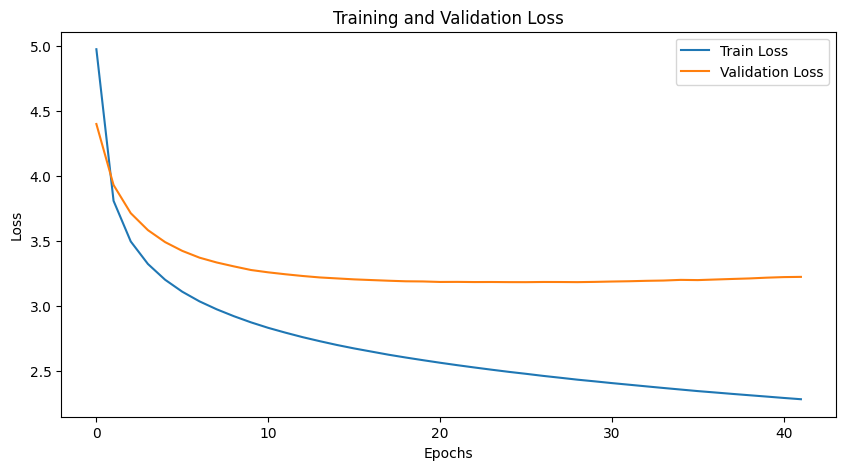

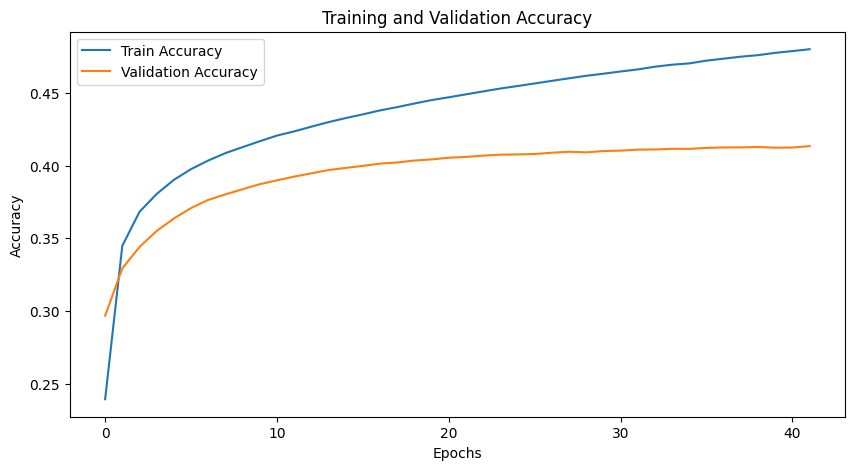

In [17]:
import matplotlib.pyplot as plt

# Lấy lịch sử huấn luyện
history_dict = history.history

# Đồ thị Loss
plt.figure(figsize=(10, 5))
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Đồ thị Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Lưu mô hình**

In [18]:
caption_model.model.save_weights('/kaggle/working/model_images_captioning.weights.h5')
caption_model.model.save('/kaggle/working/model_images_captioning.h5')

**Test với ảnh trong data test**

In [19]:
images_dir = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'
with open("/kaggle/working/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

# Với môi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'start' rồi sau đó cho vào model để dự đoán từ tiếp theo. Ta thêm từ
# vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'end' là kết thúc hoặc cho đến khi chuỗi dài 34 từ.
def greedySearch(photo):
    in_text = 'start'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'end':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

ALL caption real:  ['start a man sits on a light brown couch reading to the child in his lap , while a woman , seated to his right , plays with a younger child . end', 'start man reads to his son while mother spends time with the other child on the sofa . end', 'start a man and a woman are sitting on a couch with two children . end', 'start a female and a male each sit on the sofa with a child . end', 'start a man and a woman entertaining two children . end']
870386962.jpg
[0.1426621  0.02635292 2.134654   ... 1.303323   0.79687554 0.5117125 ]


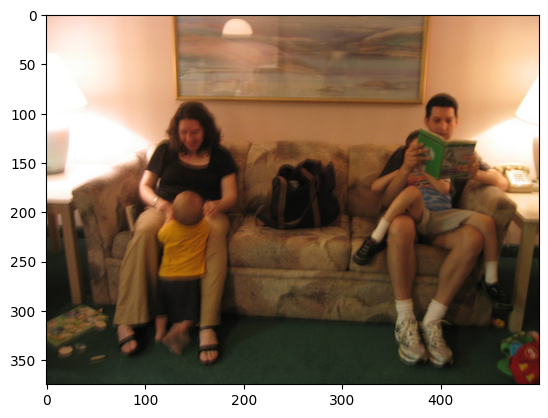

Caption:  a woman in a black shirt and black shorts is sitting on a couch with her arms crossed .


In [20]:
# Chọn ảnh từ encoding_test với chỉ số z
z = 5
pic = list(encoding_test.keys())[z]
cation_real=list(test_map.values())[z]
print("ALL caption real: ",cation_real)
print(pic)
print(encoding_test[pic])
# Trích xuất đặc trưng của ảnh từ encoding_test và chuẩn hóa lại kích thước
image = encoding_test[pic].reshape((1, 2048))

# Đọc và hiển thị ảnh
x = plt.imread(images_dir + pic)
plt.imshow(x)
plt.show()

# Gọi hàm greedySearch để tạo chuỗi mô tả cho ảnh
caption = greedySearch(image)
print("Caption: ", caption)

**Test với một ảnh bất kỳ , load mô hình lên**

In [21]:
# import numpy as np
# from keras.models import load_model
# from keras.applications.resnet import preprocess_input
# from keras.preprocessing import image as keras_image

# # Load mô hình đã lưu
# model_resnet_loaded = load_model('/kaggle/input/run-model-image-captioning/run_model_captions/resnet152_feature_extractor.h5')

# # Hàm tiền xử lý hình ảnh
# def preprocess_single_image(image_path):
#     img = keras_image.load_img(image_path, target_size=(224, 224))  # Đảm bảo kích thước ảnh đầu vào
#     x = keras_image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)
#     return x

# # Hàm trích xuất đặc trưng cho một ảnh
# def extract_features_for_image(image_path, model):
#     preprocessed_image = preprocess_single_image(image_path)
#     features = model.predict(preprocessed_image, verbose=0)
#     return features

In [22]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, GRU, Concatenate, Add, Lambda, LayerNormalization, GlobalAveragePooling1D
# from tensorflow.keras.layers import MultiHeadAttention
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import pad_sequences, to_categorical
# import tensorflow as tf

# class ImageCaptioningModel:
#     def __init__(self, vocab_size, embedding_dim, max_length):
#         self.vocab_size = vocab_size
#         self.embedding_dim = embedding_dim
#         self.max_length = max_length
#         self.model = self._build_model()

#     def _build_model(self):
#         # Tạo đầu vào cho đặc trưng ảnh
#         inputs1 = Input(shape=(2048,), name="image_features")  # Đặc trưng ảnh từ ResNet152
#         fe1 = Dropout(0.3)(inputs1)
#         fe2 = Dense(256, activation='relu')(fe1)  # Lớp Dense cho ảnh

#         # Tạo đầu vào cho caption
#         inputs2 = Input(shape=(self.max_length,), name="text_input")  # Dữ liệu caption đầu vào
#         se1 = Embedding(self.vocab_size, self.embedding_dim, mask_zero=True)(inputs2)  # Lớp embedding cho caption
#         se2 = Dropout(0.3)(se1)

#         # Multi-Head Attention cho caption
#         attn_text = MultiHeadAttention(num_heads=4, key_dim=self.embedding_dim)(se2, se2)
#         attn_text = Add()([se2, attn_text])  # Residual Connection
#         attn_text = LayerNormalization()(attn_text)  # Layer Normalization
#         se3 = GRU(256, return_sequences=True, recurrent_activation='sigmoid')(attn_text)  # GRU cho caption

#         # Attention giữa đặc trưng ảnh và caption
#         fe2_expanded = Lambda(lambda x: tf.expand_dims(x, axis=1))(fe2)  # (None, 1, 256)
#         attn_image_text = MultiHeadAttention(num_heads=4, key_dim=128)(fe2_expanded, se3)
#         attn_image_text = Add()([se3, attn_image_text])  # Residual Connection
#         attn_image_text = LayerNormalization()(attn_image_text)

#         # Gộp thông tin từ chuỗi văn bản
#         pooled_text = GlobalAveragePooling1D()(attn_image_text)  # (None, 256)

#         # Kết hợp đặc trưng ảnh và văn bản
#         merged = Concatenate()([fe2, pooled_text])  # (None, 512)

#         # Dự đoán từ tiếp theo
#         decoder = Dense(256, activation='relu')(merged)
#         outputs = Dense(self.vocab_size, activation='softmax', name="output")(decoder)  # (None, vocab_size)

#         # Định nghĩa mô hình
#         model = Model(inputs=[inputs1, inputs2], outputs=outputs)

#         # Biên dịch mô hình
#         model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])

#         return model

#     def summary(self):
#         return self.model.summary()

In [23]:
# import numpy as np
# from keras.preprocessing import image
# from keras.models import load_model
# from keras.preprocessing.sequence import pad_sequences
# import pickle
# import matplotlib.pyplot as plt
# from keras.models import load_model
# import keras

# # Bật chế độ tải không an toàn
# keras.config.enable_unsafe_deserialization()

# model = ImageCaptioningModel(vocab_size=12485, embedding_dim=300, max_length=50)
# # Tải mô hình captioning đã huấn luyện
# model.model.load_weights('/kaggle/input/run-model-image-captioning/run_model_captions/model_images_captioning.weights.h5')

# # Tải các từ điển
# with open('/kaggle/input/run-model-image-captioning/run_model_captions/wordtoix.pkl', 'rb') as f:
#     wordtoix = pickle.load(f)
# with open('/kaggle/input/run-model-image-captioning/run_model_captions/ixtoword.pkl', 'rb') as f:
#     ixtoword = pickle.load(f)

# # Hàm tìm kiếm bằng phương pháp greedy (dự đoán chuỗi mô tả)
# def greedySearch(photo,max_length=50):
#     in_text = 'start'
#     for i in range(max_length):
#         sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
#         sequence = pad_sequences([sequence], maxlen=max_length)
#         yhat = model.model.predict([photo, sequence], verbose=0)
#         yhat = np.argmax(yhat)
#         word = ixtoword[yhat]
#         in_text += ' ' + word
#         if word == 'end':
#             break
#     final = in_text.split()
#     final = final[1:-1]  # Bỏ 'startseq' và 'endseq'
#     final = ' '.join(final)
#     return final

In [24]:

# # Chọn ảnh cần test
# img_path = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg'  # Đặt đường dẫn tới ảnh cần test

# # Trích xuất đặc trưng ảnh
# image_features = extract_features_for_image(img_path,model_resnet_loaded)
# # Hiển thị ảnh
# img = plt.imread(img_path)
# plt.imshow(img)
# plt.axis('off')
# plt.show()

# # Dự đoán caption cho ảnh
# caption = greedySearch(image_features)
# print("Caption: ", caption)


In [25]:
# import tensorflow as tf
# import keras
# import numpy as np

# print("TensorFlow version:", tf.__version__)
# print("Keras version:", keras.__version__)
# print("NumPy version:", np.__version__)